In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Using device: cuda
[128, 512, 512, 512, 512, 512]
ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.1, inplace=Fal

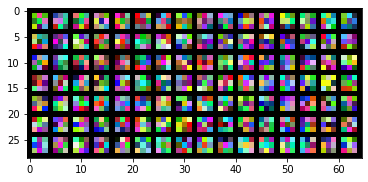

Epoch [1/40], Step [100/245], Loss: 1.3560
Epoch [1/40], Step [200/245], Loss: 1.1819
Training accuracy is: 59.0 %
Validataion accuracy is: 55.9 %
Best Model Changed 0.0 0.559
Epoch [2/40], Step [100/245], Loss: 1.0397
Epoch [2/40], Step [200/245], Loss: 0.8739
Training accuracy is: 64.0 %
Validataion accuracy is: 61.2 %
Best Model Changed 0.559 0.612
Epoch [3/40], Step [100/245], Loss: 0.8685
Epoch [3/40], Step [200/245], Loss: 0.9811
Training accuracy is: 72.0 %
Validataion accuracy is: 69.5 %
Best Model Changed 0.612 0.695
Epoch [4/40], Step [100/245], Loss: 0.7495
Epoch [4/40], Step [200/245], Loss: 0.7179
Training accuracy is: 78.5 %
Validataion accuracy is: 70.6 %
Best Model Changed 0.695 0.706
Epoch [5/40], Step [100/245], Loss: 0.7110
Epoch [5/40], Step [200/245], Loss: 0.6496
Training accuracy is: 76.5 %
Validataion accuracy is: 73.9 %
Best Model Changed 0.706 0.739
Epoch [6/40], Step [100/245], Loss: 0.6826
Epoch [6/40], Step [200/245], Loss: 0.5846
Training accuracy is: 79.5

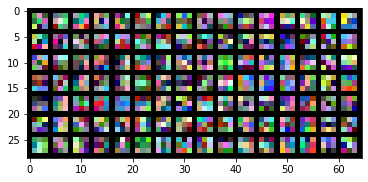

<Figure size 432x288 with 0 Axes>

In [94]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 40
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None
print(hidden_size)


#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------

data_aug_transforms = [transforms.RandomHorizontalFlip(p=0.5), 
                       transforms.RandomGrayscale(p=0.1),
                       transforms.RandomCrop(size = 32,padding = 4)]

norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='/datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='/datasets/',
                                          train=False,
                                          transform=test_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()

        layers = []

        self.layers = nn.Sequential(
            nn.Conv2d(input_size,hidden_layers[0],3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_layers[0]),
            nn.Dropout(0.1),
            
            nn.Conv2d(hidden_layers[0],hidden_layers[1],3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_layers[1]),
            nn.Dropout(0.1),
            
            nn.Conv2d(hidden_layers[1],hidden_layers[2],3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_layers[2]),
            nn.Dropout(0.1),
            
            nn.Conv2d(hidden_layers[2],hidden_layers[3],3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_layers[3]),
            nn.Dropout(0.1),
            
            nn.Conv2d(hidden_layers[3],hidden_layers[4],3,padding=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_layers[4]),
            nn.Dropout(0.1),
            
            nn.Flatten(),
            nn.Linear(hidden_layers[4],num_classes)
            
            
            )


    def forward(self, x):

        out = self.layers(x)

  
        return out



def PrintModelSize(model, disp=True):


    model_sz = 0
    print('Trainable parameters:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, '\t', param.numel())
            model_sz += param.numel()
    print()
    print('Total trainable parameters', '\t', model_sz)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz

def VisualizeFilter(model):

    
    
    #extracting the model features at the particular layer number
    layer_num = 0
    layer = model.layers[0]
    
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
      #getting the weight tensor data
      weight_tensor = model.layers[layer_num].weight.data
      weight_np = np.array(weight_tensor.cpu().numpy(), np.float32)
      # Added extra
      
      columns = 16
      padding = 1
      padding_mat_x = np.zeros((3, padding, 3))
      padding_mat_y = np.zeros((padding, (3+padding)*columns+padding, 3))
      
      row = padding_mat_x
      full_img = padding_mat_y
      #looping through all the kernels
      for kernel_i in range(weight_tensor.shape[0]):
          if(kernel_i % columns == 0 and kernel_i != 0):
            # equalize dimensions along axis 0
            full_img = np.concatenate((full_img,  row), axis=0)
            full_img = np.concatenate((full_img, padding_mat_y), axis=0)
            # equalize dimensions along axis 1
            row = padding_mat_x
            
          kernel_ = np.transpose(weight_np[kernel_i], (2,1,0))
          
          # standardize the filter
          kernel_ = (kernel_ - kernel_ .min()) / (kernel_.max() - kernel_ .min())
          # Apply padding to the entire row 
          row = np.concatenate((row, kernel_), axis=1)
          row = np.concatenate((row,  padding_mat_x), axis=1)
        
    plt.imshow(full_img)
    plt.show()
    plt.savefig('plot.png')
      
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)
# Print model size

PrintModelSize(model)

VisualizeFilter(model)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

#Training parameters
lr = learning_rate
total_step = len(train_loader)
val_accuracy = 0.
best_model = None

# Early stopping parameters
accuracy_static_counter = 0
threshold_count = 6

# Loss list 
loss_history = []
train_accuracy = []
validation_accuracy = []

def print_loss_curve(loss_history):
    samples_per_epoch = (int)((num_training/batch_size)/100)
    indieces = list(filter(lambda x: x %
                           samples_per_epoch == 0, range(0, len(loss_res))))
    final_samples = (np.asarray(loss_res)[indieces])
    x = range(0, len(final_samples))
    plt.plot(x, final_samples)
    plt.xticks(x)
    plt.ylabel("train loss")
    plt.xlabel("epochs")
    plt.show()

# Train the model

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    loss_history.append(loss.item())

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        ##For Calculating Training Accuracy
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print('Training accuracy is: {} %'.format(100 * correct / total))
        train_accuracy.append(100 * correct / total)
        correct,total = 0,0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validataion accuracy is: {} %'.format(100 * correct / total))
        validation_accuracy.append(100 * correct / total)


    if accuracy_static_counter == threshold_count:
        print('Early stopping as accuracy does not seem to improve....')
        break
    else:
        if((correct/total)>val_accuracy):
          print('Best Model Changed',val_accuracy,correct/total)
          best_model = model
          val_accuracy = (correct/total)

        else:
            accuracy_static_counter += 1

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    model.train()

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()

model = best_model

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))


VisualizeFilter(model)
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')




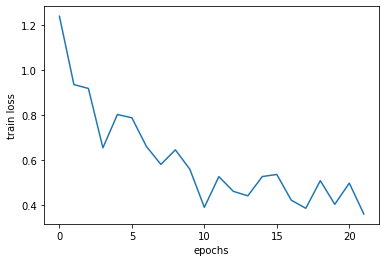

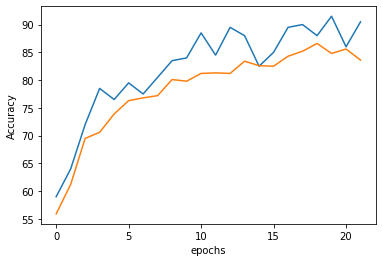

In [95]:
plt.plot(loss_history)
plt.ylabel("train loss")
plt.xlabel("epochs")
plt.show()
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.show()
